<a href="https://colab.research.google.com/github/Brymer-Meneses/PyTorch-Basics/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
print(f'Now running on {device}')

Now running on cuda


In [3]:
batchSize = 64

T = transforms.ToTensor()
trainData = torchvision.datasets.MNIST('./data', download = True, transform=T,  train = True)
trainLoader = torch.utils.data.DataLoader(trainData, shuffle = True, batch_size = batchSize)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataIter = iter(trainLoader)

imgs, labels = dataIter.next()

In [5]:
def imshow(imgs):
  imgs = torchvision.utils.make_grid(imgs)
  npimgs = imgs.numpy()
  plt.figure(figsize =(8,8))
  plt.imshow(np.transpose(npimgs, (1,2,0)), cmap = 'Greys_r')
  plt.xticks([])
  plt.yticks([])
  plt.show()

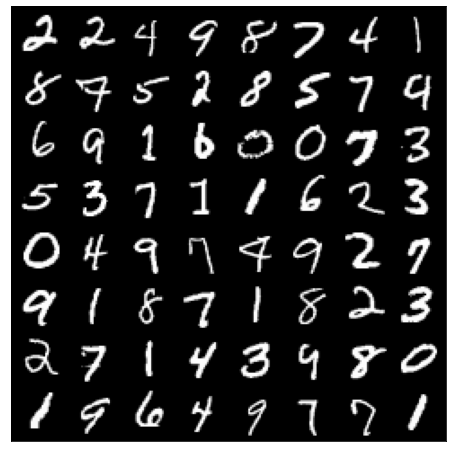

In [7]:
imshow(imgs)

In [14]:
Z_dim = 100
H_dim = 128
X_dim = imgs.view(imgs.size(0), -1).size(1)

print(Z_dim, H_dim, X_dim)

100 128 784


In [15]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(Z_dim, H_dim),
        nn.ReLU(),
        nn.Linear(H_dim, X_dim), 
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.model(input)


In [16]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(X_dim, H_dim),
        nn.ReLU(),
        nn.Linear(H_dim, 1),
        nn.Sigmoid()
    )
  def forward(self, input):
    return self.model(input)

In [17]:
G = Generator().to(device)
D = Discriminator().to(device)

In [18]:
print(G)
print(D)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [19]:
lr = 1e-3
n_epochs = 20

g_opt = optim.Adam(G.parameters(), lr = lr)
d_opt = optim.Adam(D.parameters(), lr = lr)


Epoch: 1, G_loss: 4453.133109211922, D_loss: 0.12919327070309058


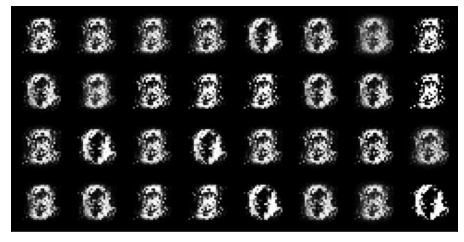

Epoch: 2, G_loss: 3782.0049378871918, D_loss: 0.13277498645576905


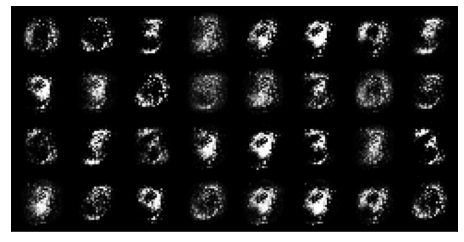

Epoch: 3, G_loss: 3733.751275062561, D_loss: 0.2017805682840759


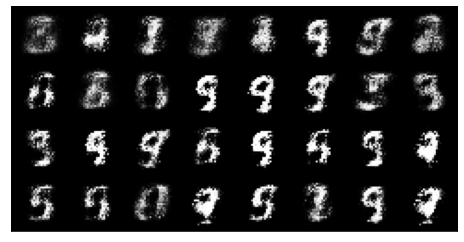

Epoch: 4, G_loss: 3430.7885563373566, D_loss: 0.32908075121737745


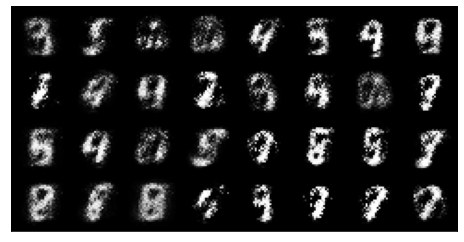

Epoch: 5, G_loss: 3378.7437987327576, D_loss: 0.5261668748438739


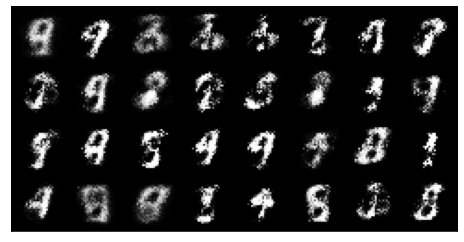

Epoch: 6, G_loss: 3164.9288606643677, D_loss: 0.5987787437178432


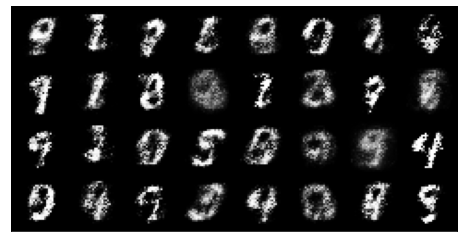

Epoch: 7, G_loss: 2880.5626430511475, D_loss: 0.7125704155674876


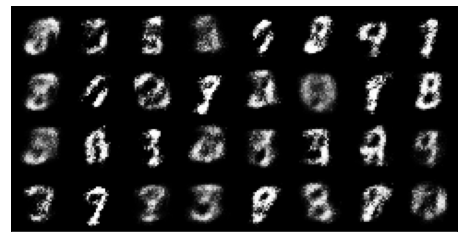

Epoch: 8, G_loss: 2573.485159754753, D_loss: 0.7892349585731909


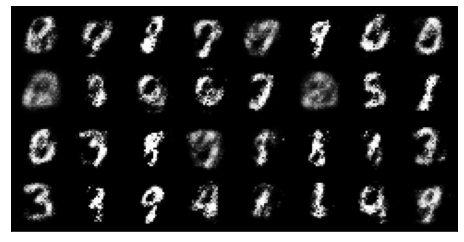

Epoch: 9, G_loss: 2377.1120097637177, D_loss: 0.7962926623345946


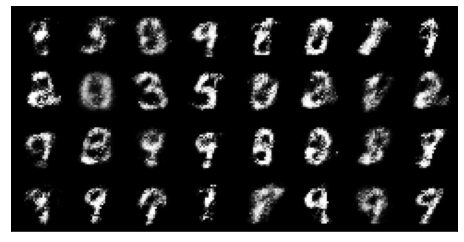

Epoch: 10, G_loss: 2211.5444226264954, D_loss: 0.8395498433092764


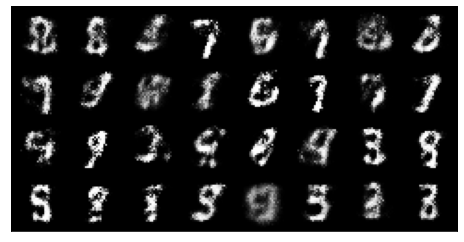

In [20]:
# Training loop

for epoch in range(n_epochs):
  G_loss_run = 0.0
  D_loss_run = 0.0

  for i, (imgs, labels) in enumerate(trainLoader):
    imgs = imgs.view(-1, 28*28).to(device)
    batch_size = imgs.size(0)

    one_labels = torch.ones(batch_size ,1).to(device)
    zero_labels = torch.zeros(batch_size ,1).to(device)

    z = torch.randn(batch_size, Z_dim).to(device)

    D_real = D(imgs)
    D_fake = D(G(z))

    D_real_loss = F.binary_cross_entropy(D_real, one_labels)
    D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)

    D_loss = D_real_loss + D_fake_loss

    d_opt.zero_grad()
    D_loss.backward()
    d_opt.step()

    z = torch.randn(batch_size, Z_dim).to(device)

    D_fake = D(G(z))
    G_loss = F.binary_cross_entropy(D_fake, one_labels)

    g_opt.zero_grad()
    G_loss.backward()
    g_opt.step()

    G_loss_run += G_loss.item()
    D_loss_run += D_loss.item()

 
  print(f'Epoch: {epoch+1}, G_loss: {G_loss_run}, D_loss: {D_loss_run/(i+1)}')

  samples = G(z).detach()
  samples = samples.reshape(samples.size(0), 1, 28, 28).cpu()
  imshow(samples)